# Classification - HR Dataset Bronson

In [1]:
## Importing packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score, roc_curve, accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor



        
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible


In [2]:
df = pd.read_csv("HR_comma_sep.csv")

## Exploratory Analysis, Cleaning Dataset 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
cols = df.columns.tolist()
cols
cols[-1:]

['salary']

In [5]:
# Rearrange Columns to have target, "left", appear as first column
cols = cols[-4:] + cols[:-4]
df = df[cols]

In [6]:
# Clean and rename columns 

df.rename(columns = {"promotion_last_5years" : "promotion_last_5_years", "sales" : "division", 
                     "number_project" : "number_of_projects", "average_montly_hours" : "average_monthly_hours", 
                     "time_spend_company" : "time_spent_with_the_company", 
                     "Work_accident" : "work_accidents"}, inplace=True)


# Exploring Data Distribution

In [7]:
df.left.value_counts()


0    11428
1     3571
Name: left, dtype: int64

In [8]:
print("The percentage of employees who have stayed at the company is", round((11428/df.shape[0]) * 100.0, 2),"%")
print("The percentage of employees who have left the company is", round((3571/df.shape[0]) * 100.0, 2),"%")

The percentage of employees who have stayed at the company is 76.19 %
The percentage of employees who have left the company is 23.81 %


In [9]:
df.satisfaction_level.mean()


0.6128335222348166

In [10]:
df.satisfaction_level.describe()


count    14999.000000
mean         0.612834
std          0.248631
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

In [11]:
df.number_of_projects.mean()

3.80305353690246

In [12]:
df.work_accidents.mean()

0.1446096406427095

In [13]:
df.last_evaluation.mean()

0.7161017401159978

In [14]:
df.last_evaluation.describe()

count    14999.000000
mean         0.716102
std          0.171169
min          0.360000
25%          0.560000
50%          0.720000
75%          0.870000
max          1.000000
Name: last_evaluation, dtype: float64

(array([ 351.,  885., 2371., 1590., 1372., 1518., 1423., 1970., 1669.,
        1850.]),
 array([0.36 , 0.424, 0.488, 0.552, 0.616, 0.68 , 0.744, 0.808, 0.872,
        0.936, 1.   ]),
 <BarContainer object of 10 artists>)

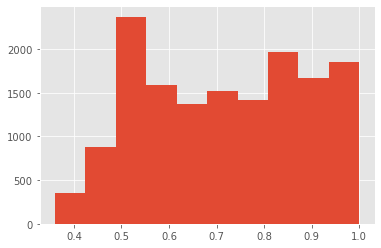

In [15]:
plt.hist(df["last_evaluation"])

Text(0.5, 1.0, 'Salary by Pay Bracket')

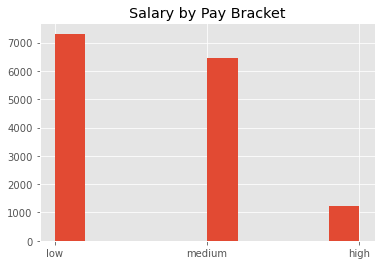

In [16]:
plt.hist(df["salary"])
plt.title("Salary by Pay Bracket")

(array([12830.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2169.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

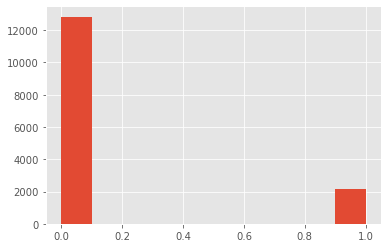

In [17]:
plt.hist(df["work_accidents"])

In [18]:
## Employees who have left 
mask1 = df["left"] == 1

In [19]:
## Employees who are still with the company 
mask2 = df["left"] == 0

In [20]:
## Dataframes for each of the above masks 
df_left = df[mask1]
df_stayed = df[mask2]

In [21]:
df_left.satisfaction_level.mean()

0.44009801176140917

In [22]:
# The average satisfaction for employees who stayed is significantly higher 
df_stayed.satisfaction_level.mean()

0.666809590479516

In [23]:
len(df_left)

3571

In [24]:
len(df_stayed)

11428

In [25]:
df_left.work_accidents.value_counts()

0    3402
1     169
Name: work_accidents, dtype: int64

In [26]:
## Work accidents are higher among employees who have stayed. Perhaps the company deals well with post-accident situations


df_stayed.work_accidents.value_counts()

0    9428
1    2000
Name: work_accidents, dtype: int64

In [27]:
print("The average satisfaction level for employees who stayed is: ", round(df_stayed.satisfaction_level.mean(), 4))
print("The average satisfaction level for employees who left is: ", round(df_left.satisfaction_level.mean(),4))

The average satisfaction level for employees who stayed is:  0.6668
The average satisfaction level for employees who left is:  0.4401


# Exploring different salary bracket s

In [28]:
# Creating different dataframes for low, medium, and high salary brackets  
mask3 = df["salary"] == 'low'
mask5 = df["salary"] == 'medium'
mask4 = df["salary"] == 'high'

df_low = df[mask3]
df_medium = df[mask5]
df_high = df[mask4]

In [29]:
df_low.left.value_counts()

0    5144
1    2172
Name: left, dtype: int64

In [30]:
print(round(2172/(5144 + 2172) * 100.0, 4), "% of employees with low salary have left the company")

29.6884 % of employees with low salary have left the company


In [31]:
df_high.left.value_counts()

0    1155
1      82
Name: left, dtype: int64

In [32]:
print(round(82/(1155 + 82) * 100.0, 4), "% of employees with high salary have left the company")

6.6289 % of employees with high salary have left the company


In [33]:
df_medium.left.value_counts()

0    5129
1    1317
Name: left, dtype: int64

In [34]:
print(round(1317/(5129 + 1317) * 100.0, 4), "% of employees with medium salary have left the company")

20.4313 % of employees with medium salary have left the company


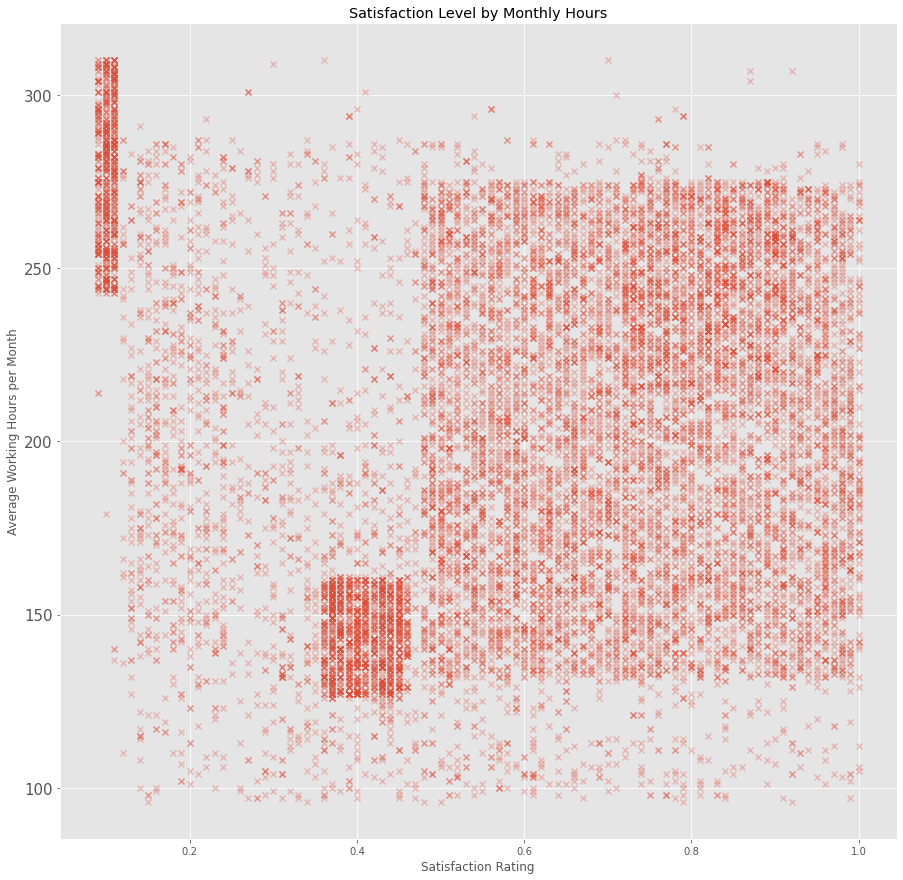

In [35]:
# Plotting satisfaction level by number of monthly hours worked
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 15)

plt.figure(figsize=(15,15))

plt.scatter(df["satisfaction_level"],df["average_monthly_hours"], alpha = .3, marker="x" )

plt.title("Satisfaction Level by Monthly Hours")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Average Working Hours per Month")
plt.show()


In [36]:
df.left.mean()

0.2380825388359224

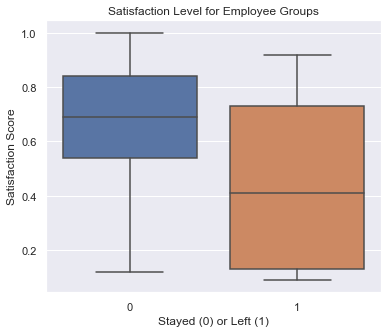

In [155]:
p = sns.boxplot(x='left', y='satisfaction_level', data=df)

p.set(xlabel = "Stayed (0) or Left (1)", ylabel ="Satisfaction Score", title="Satisfaction Level for Employee Groups");
sns.set(rc={'figure.figsize':(6,5)})


## Feature Engineering: Dummy Variable and Shifting of Categorical Variables

In [38]:
df.division.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: division, dtype: int64

In [39]:
## Dummy Variables created for division 

df = pd.get_dummies(df, columns=['division'], drop_first=False)

In [41]:
## Dropped accounting division as it is one of the smaller divisions, in order to prevent multicollinearity 

df.drop(["division_accounting"], axis=1)

,left,promotion_last_5_years,salary,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical
0,1,0,low,0.38,0.53,2,157,3,0,0,0,0,0,0,0,1,0,0
1,1,0,medium,0.80,0.86,5,262,6,0,0,0,0,0,0,0,1,0,0
2,1,0,medium,0.11,0.88,7,272,4,0,0,0,0,0,0,0,1,0,0
3,1,0,low,0.72,0.87,5,223,5,0,0,0,0,0,0,0,1,0,0
4,1,0,low,0.37,0.52,2,159,3,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1,0,low,0.40,0.57,2,151,3,0,0,0,0,0,0,0,0,1,0
14995,1,0,low,0.37,0.48,2,160,3,0,0,0,0,0,0,0,0,1,0
14996,1,0,low,0.37,0.53,2,143,3,0,0,0,0,0,0,0,0,1,0
14997,1,0,low,0.11,0.96,6,280,4,0,0,0,0,0,0,0,0,1,0


In [42]:
df.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [43]:
## df_all_dummies is a df where we make both salary and division into dummy variables 

df_all_dummies = pd.get_dummies(df, columns=['salary'], drop_first=False)


In [45]:
## Dropping medium salary level to avoid multicollinearity  

df_all_dummies.drop(["salary_medium"], axis=1)

,left,promotion_last_5_years,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low
0,1,0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,0,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,0,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1,0,0.40,0.57,2,151,3,0,0,0,0,0,0,0,0,0,1,0,0,1
14995,1,0,0.37,0.48,2,160,3,0,0,0,0,0,0,0,0,0,1,0,0,1
14996,1,0,0.37,0.53,2,143,3,0,0,0,0,0,0,0,0,0,1,0,0,1
14997,1,0,0.11,0.96,6,280,4,0,0,0,0,0,0,0,0,0,1,0,0,1


In [47]:
df_cat_num = df

In [48]:
# Dataframe where categorical salary is replaced with a numberical representation of the salary level

df_cat_num = df_cat_num.replace('low', 1)
df_cat_num = df_cat_num.replace('medium', 2)
df_cat_num = df_cat_num.replace('high', 3)

In [51]:
df_d = df_all_dummies
df_n = df_cat_num

In [52]:
# sns.pairplot(df)

#  KNN with df with all Dummy variables  (df_d)

In [53]:
df_d.head()

,left,promotion_last_5_years,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,...,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,1,0,0.38,0.53,2,157,3,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,0.80,0.86,5,262,6,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0.11,0.88,7,272,4,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,0,0.72,0.87,5,223,5,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,1,0,0.37,0.52,2,159,3,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [54]:
X = df_d.iloc[:, 1:]


In [55]:
X.head()

,promotion_last_5_years,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [56]:
## Making y into numpy array for train test split 
y = df_d.loc[:, ["left"]]
y = np.ravel(y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [58]:
# Roughly 12,000 data points in training set 
print(X_train.shape)

(11999, 20)


In [59]:
y_train.shape

(11999,)

In [60]:
# 3,000 rows 20 features in test set 
print(X_test.shape)

(3000, 20)


In [61]:
# Fitting model to train data, prediction 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


In [62]:
## Performance metrics below 

print("Accuracy score for df_d: " , metrics.accuracy_score(y_test, y_pred))
print("Recall score for df_d: ",metrics.recall_score(y_test, y_pred))
print("Precision score for df_d: ",metrics.precision_score(y_test, y_pred))
print("f1 score for df_d: ", metrics.f1_score(y_test, y_pred))

Accuracy score for df_d:  0.9263333333333333
Recall score for df_d:  0.9123287671232877
Precision score for df_d:  0.8092345078979344
f1 score for df_d:  0.8576947842884739


In [64]:
## Prediction of 27.4% of employees as having left 

y_pred.mean()

0.2743333333333333

In [65]:
print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test)))


kNN confusion matrix: 

 [[2113  157]
 [  64  666]]


In [66]:
print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test)))


kNN confusion matrix: 

 [[2113  157]
 [  64  666]]


In [156]:
df_d 

,left,promotion_last_5_years,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,...,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,1,0,0.38,0.53,2,157,3,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,0.80,0.86,5,262,6,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0.11,0.88,7,272,4,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,0,0.72,0.87,5,223,5,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,1,0,0.37,0.52,2,159,3,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1,0,0.40,0.57,2,151,3,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14995,1,0,0.37,0.48,2,160,3,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14996,1,0,0.37,0.53,2,143,3,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14997,1,0,0.11,0.96,6,280,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0


## KNN for 2nd df, using a numerical value to represent salary rather than a categorical value

In [67]:
df_n.head(5)

,left,promotion_last_5_years,salary,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical
0,1,0,1,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0
1,1,0,2,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0
2,1,0,2,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0


In [68]:
X_2 = df_n.iloc[:, 1:]
y2 = df_n.loc[:, ["left"]]
y2 = np.ravel(y2)

In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y2, test_size=0.2, random_state=50)

In [73]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train2)
y_pred2 = knn.predict(X_test2)

In [74]:
print("Accuracy score for df_n: " , metrics.accuracy_score(y_test2, y_pred2))
print("Recall score for df_n: ",metrics.recall_score(y_test2, y_pred2))
print("Precision score for df_n: ",metrics.precision_score(y_test2, y_pred2))
print("f1 score for df_n: ", metrics.f1_score(y_test2, y_pred2))

Accuracy score for df_n:  0.9276666666666666
Recall score for df_n:  0.9178082191780822
Precision score for df_n:  0.8101571946795647
f1 score for df_n:  0.8606294155427102


In [75]:
y_pred2.mean()

0.27566666666666667

## Cross Validation df_d

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

print(scores)

[0.93133333 0.92933333 0.92133333 0.92466667 0.92133333 0.93066667
 0.95       0.938      0.95266667 0.94863242]


In [77]:
print(scores.mean())

0.9347965754947744


Text(0, 0.5, 'Cross-Validated Accuracy')

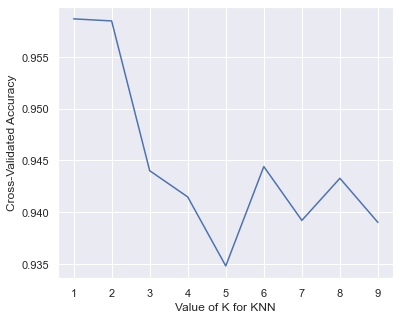

In [78]:
k_range = list(range(1,10))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-Validated Accuracy")

Text(0, 0.5, 'Cross-Validated Precision')

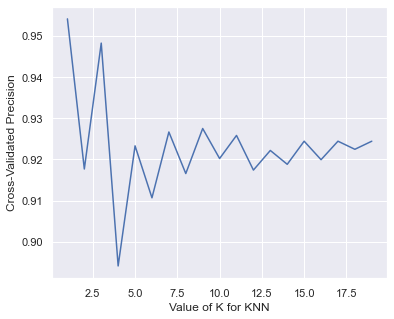

In [79]:
k_range = list(range(1,20))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'recall')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-Validated Precision")

In [80]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


In [81]:

print("Accuracy score for df_d: " , metrics.accuracy_score(y_test, y_pred))
print("Recall score for df_d: ",metrics.recall_score(y_test, y_pred))
print("Precision score for df_d: ",metrics.precision_score(y_test, y_pred))
print("f1 score for df_d: ", metrics.f1_score(y_test, y_pred))

Accuracy score for df_d:  0.9333333333333333
Recall score for df_d:  0.9232876712328767
Precision score for df_d:  0.823960880195599
f1 score for df_d:  0.8708010335917312


In [82]:
## Using 9 neighbors gives an increase in recall, and a slight decrease in precision for df_d

In [83]:
scores = cross_val_score(knn, X, y, cv=10, scoring = 'recall')
print("Recall:", scores.mean())

scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
print("Accuracy:", scores.mean())

scores = cross_val_score(knn, X, y, cv=10, scoring = 'precision')
print("Precision:", scores.mean())

scores = cross_val_score(knn, X, y, cv=10, scoring = 'f1')
print("F1:", scores.mean())


Recall: 0.9274681939815033
Accuracy: 0.9389965754947742
Precision: 0.8351424930917917
F1: 0.8787793568875765


## df_n cross val

In [84]:
## df_n has a higher accuracy, precision, and k1 level than df_d 

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_2, y2, cv=10, scoring='accuracy')

print(scores)
print(scores.mean())

[0.93466667 0.93       0.93266667 0.92266667 0.926      0.92666667
 0.952      0.936      0.95333333 0.95063376]
0.9364633755837225


Text(0, 0.5, 'Cross-Validated Precision')

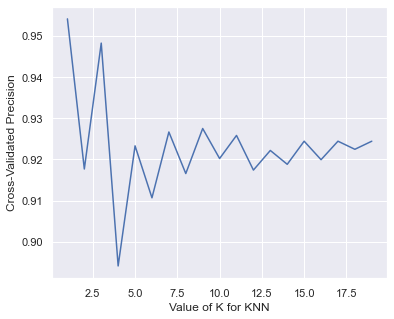

In [85]:
k_range = list(range(1,20))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'recall')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-Validated Precision")

In [86]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train2, y_train2)
y_pred2 = knn.predict(X_test2)

In [87]:
print("Accuracy score for df_n: " , metrics.accuracy_score(y_test2, y_pred2))
print("Recall score for df_n: ",metrics.recall_score(y_test2, y_pred2))
print("Precision score for df_n: ",metrics.precision_score(y_test2, y_pred2))
print("f1 score for df_n: ", metrics.f1_score(y_test2, y_pred2))

Accuracy score for df_n:  0.9306666666666666
Recall score for df_n:  0.9205479452054794
Precision score for df_n:  0.8175182481751825
f1 score for df_n:  0.8659793814432989


In [88]:
## df_d seems to be outperforming df_n, I will move forward with using this df

## Grid Search 

In [89]:
## k_range = list(range(1, 25))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='recall')
grid.fit(X, y);

## Grid search confirms 9 neighbors works well for recall 

df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head(30)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 1}
Best estimator:  KNeighborsClassifier(n_neighbors=1)
Best score:  0.9540616246498599


In [90]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))


0.9333333333333333
0.9232876712328767
0.8708010335917312
0.9232876712328767


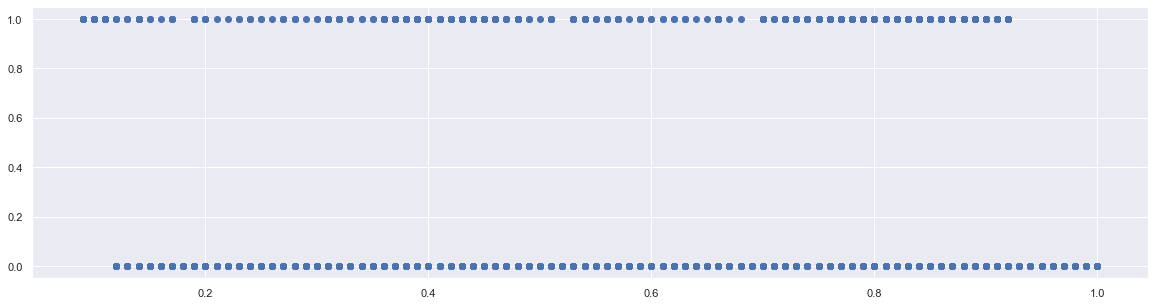

In [91]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.scatter(X_train.satisfaction_level, y_train)

In [92]:
X_train.satisfaction_level.describe()

count    11999.000000
mean         0.615177
std          0.248203
min          0.090000
25%          0.440000
50%          0.650000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

## Confusion Matrix for KNN

In [93]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_train)

In [94]:
print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test)))


kNN confusion matrix: 

 [[2126  144]
 [  56  674]]


In [95]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))

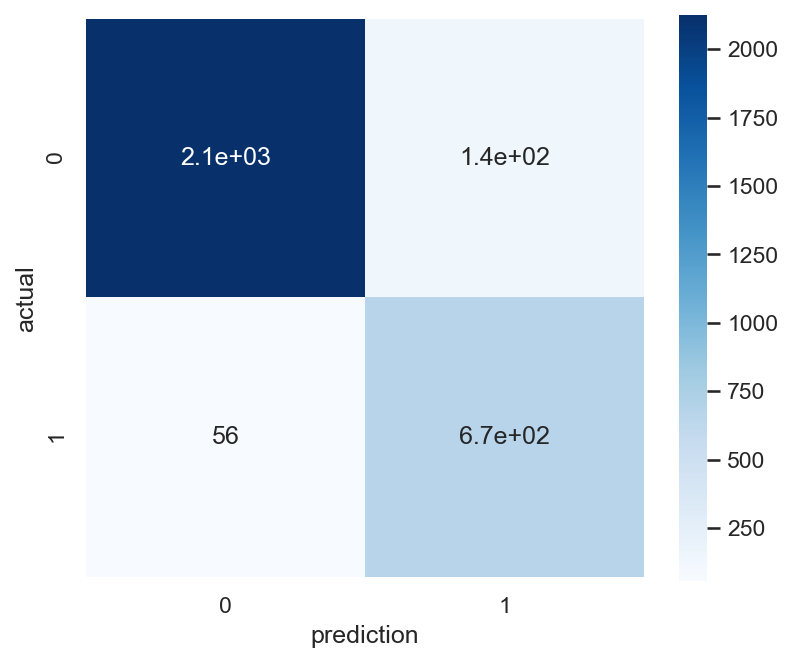

In [96]:
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('prediction')
plt.ylabel('actual');


In [97]:
## sns.pairplot(df.sample(100), hue="left")

## Logistic Regression

In [98]:
lm1 = LogisticRegression(C=1) 
lm1.fit(X_train[['satisfaction_level']], y_train)

LogisticRegression(C=1)

In [99]:
lm1.score(X_train[['satisfaction_level']], y_train)


0.7718143178598217

In [100]:
lr = LogisticRegression(C=.95) 


In [101]:
std_scale = StandardScaler()

In [102]:
X_train_scaled =  std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

In [103]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.95)

In [104]:
y_predict = lr.predict(X_train_scaled)

In [105]:
lr.score(X_train_scaled, y_train)

0.7884823735311276

In [106]:
lr.fit(X_train_scaled, y_train)
print("The accuracy score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test_scaled, y_test)))

The accuracy score for logistic regression is
Training:  78.85%
Test set:  77.67%


In [107]:
# Prediction for probability of target being 0 or 1 

lr.predict_proba(X_test_scaled)[:30,]

array([[0.85629451, 0.14370549],
       [0.80458072, 0.19541928],
       [0.92661408, 0.07338592],
       [0.98483828, 0.01516172],
       [0.88889867, 0.11110133],
       [0.62842667, 0.37157333],
       [0.53960298, 0.46039702],
       [0.93012142, 0.06987858],
       [0.33207785, 0.66792215],
       [0.90332561, 0.09667439],
       [0.92591097, 0.07408903],
       [0.92984059, 0.07015941],
       [0.23824558, 0.76175442],
       [0.55816646, 0.44183354],
       [0.58867965, 0.41132035],
       [0.38302407, 0.61697593],
       [0.96504172, 0.03495828],
       [0.85987059, 0.14012941],
       [0.80000772, 0.19999228],
       [0.63074141, 0.36925859],
       [0.95787327, 0.04212673],
       [0.9950458 , 0.0049542 ],
       [0.57363312, 0.42636688],
       [0.87415786, 0.12584214],
       [0.33349358, 0.66650642],
       [0.98352637, 0.01647363],
       [0.87653097, 0.12346903],
       [0.82775458, 0.17224542],
       [0.75859261, 0.24140739],
       [0.32930668, 0.67069332]])

Text(64.375, 0.5, 'actual')

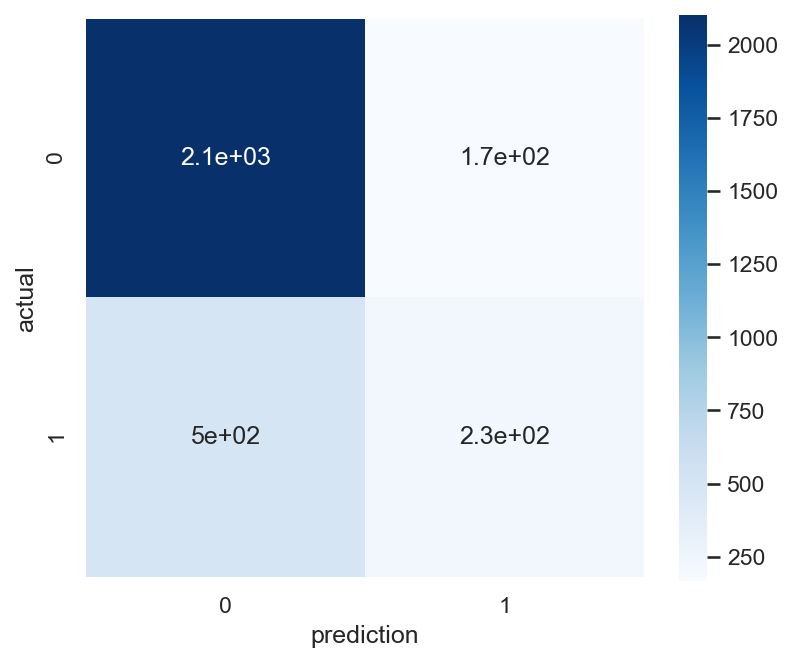

In [108]:
logit_confusion = confusion_matrix(y_test, lr.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('prediction')
plt.ylabel('actual')


In [109]:
y_predict = lr.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))


Default threshold:
Precision: 0.5761,   Recall: 0.3110,   f1: 0.4039,  accuracy: 0.7767


In [110]:
y_predict = (lr.predict_proba(X_test_scaled)[:,1] > 0.06)
print(".06 threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))



.06 threshold:
Precision: 0.3026,   Recall: 0.9849,   f1: 0.4630,  accuracy: 0.4440


In [111]:
y_predict = (lr.predict_proba(X_test_scaled)[:,1] > 0.1)
print(".06 threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))



.06 threshold:
Precision: 0.3536,   Recall: 0.9658,   f1: 0.5176,  accuracy: 0.5620


In [112]:
y_predict = (lr.predict_proba(X_test_scaled)[:,1] > 0.2)
print(".06 threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))



.06 threshold:
Precision: 0.4568,   Recall: 0.8260,   f1: 0.5883,  accuracy: 0.7187


In [113]:
lr.coef_, lr.intercept_


(array([[-0.20326418, -1.01218029,  0.13615246, -0.37694884,  0.22923133,
          0.40027642, -0.52345103, -0.0123821 , -0.1119835 , -0.00775935,
          0.0697468 , -0.08665237, -0.00182524, -0.00667515, -0.00728674,
          0.04021683,  0.05932206, -0.42350361,  0.25624158, -0.02406612]]),
 array([-1.60602028]))

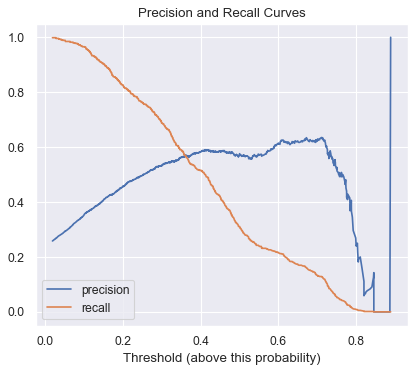

In [115]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability)');
plt.title('Precision and Recall Curves');


In [116]:
# Adjusting C levels 
lr = LogisticRegression(C=20) 


In [117]:
lr.fit(X_train_scaled, y_train)
y_predict = lr.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))


Default threshold:
Precision: 0.5747,   Recall: 0.3110,   f1: 0.4036,  accuracy: 0.7763


In [118]:
lr = LogisticRegression(C=.001) 


In [119]:
lr.fit(X_train_scaled, y_train)
y_predict = lr.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f},   f1: {:6.4f},  accuracy: {:6.4f}".format(precision_score(y_test,
                                                    y_predict),recall_score(y_test, y_predict),
                                                    f1_score(y_test, y_predict), accuracy_score(y_test, y_predict)))


Default threshold:
Precision: 0.6482,   Recall: 0.1767,   f1: 0.2777,  accuracy: 0.7763


In [120]:
lr = LogisticRegression(C=.95) 
lr.fit(X_train_scaled, y_train)


LogisticRegression(C=0.95)

## ROC

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.8248723673888119


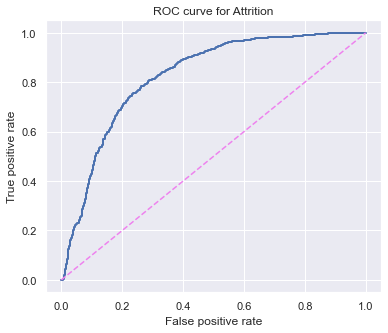

In [122]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Attrition');
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

In [123]:
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lr.predict_proba(X_test_scaled))))

Log-loss on logit: 0.4311


In [124]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test_scaled))))

Log-loss on dummy classifier: 0.5550


In [125]:
print("Logistic accuracy: {:6.4f}".format(lr.score(X_test_scaled, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))

Logistic accuracy: 0.7767
Dummy accuracy: 0.7567


## Decision Tree

In [126]:
decisiontree = DecisionTreeClassifier(max_depth=4)

In [127]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

In [128]:
def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])


In [129]:
quick_test_afew_times(decisiontree, X, y)

0.9684222222222221

In [130]:
decisiontree = DecisionTreeClassifier(max_depth=20)

In [131]:
print("Accuracy for quick test a few times", quick_test_afew_times(decisiontree, X, y))

Accuracy for quick test a few times 0.9778666666666667


In [132]:
decisiontree = DecisionTreeClassifier(max_depth=20)

Text(0, 0.5, 'Cross-Validated Recall')

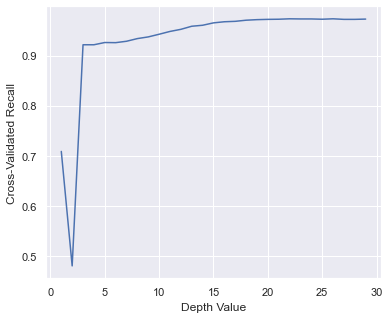

In [133]:
d_range = list(range(1,30))
d_scores = []

for d in d_range:
    decisiontree = DecisionTreeClassifier(max_depth=d)
    score_d = cross_val_score(decisiontree, X, y, cv=10, scoring = 'recall')
    d_scores.append(score_d.mean())
 

plt.plot(d_range, d_scores)
plt.xlabel("Depth Value")
plt.ylabel("Cross-Validated Recall")

In [134]:
decisiontree = DecisionTreeClassifier(max_depth=10)

In [135]:
decisiontree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10)

In [136]:
scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'recall')
print("recall:", scores.mean())

recall: 0.942307090433939


In [137]:
scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'accuracy')
print("accuracy:", scores.mean())

accuracy: 0.9805991105181231


In [138]:
decisiontree = DecisionTreeClassifier(max_depth=20)
decisiontree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=20)

In [139]:
scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'recall')
print("recall:", scores.mean())

scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'accuracy')
print("accuracy:", scores.mean())

scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'precision')
print("precision:", scores.mean())

scores = cross_val_score(decisiontree, X, y, cv=10, scoring = 'f1')
print("F1:", scores.mean())


recall: 0.9719887955182074
accuracy: 0.9831999555259061
precision: 0.9579082604877985
F1: 0.9646304275175105


In [140]:
y_pred = decisiontree.predict(X_test)

In [141]:
print("Accuracy score for Random Forest: " , metrics.accuracy_score(y_test, y_pred))
print("Recall score for Random Forest: ",metrics.recall_score(y_test, y_pred))
print("Precision score for Random Forest: ",metrics.precision_score(y_test, y_pred))
print("f1 score for Random Forest: ", metrics.f1_score(y_test, y_pred))

Accuracy score for Random Forest:  0.9763333333333334
Recall score for Random Forest:  0.9684931506849315
Precision score for Random Forest:  0.9364238410596026
f1 score for Random Forest:  0.9521885521885521


## Random Forest

In [142]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, y_train)

RandomForestClassifier()

In [143]:
scores = cross_val_score(randomforest, X, y, cv=10, scoring = 'recall')
print("recall:", scores.mean())

scores = cross_val_score(randomforest, X, y, cv=10, scoring = 'accuracy')
print("accuracy:", scores.mean())

scores = cross_val_score(randomforest, X, y, cv=10, scoring = 'precision')
print("precision:", scores.mean())


recall: 0.9722689075630253
accuracy: 0.9920666666666668
precision: 0.9927493552503615


In [144]:
y_pred = randomforest.predict(X_test)

In [145]:
print("Accuracy score for Random Forest: " , metrics.accuracy_score(y_test, y_pred))
print("Recall score for Random Forest: ",metrics.recall_score(y_test, y_pred))
print("Precision score for Random Forest: ",metrics.precision_score(y_test, y_pred))
print("f1 score for Random Forest: ", metrics.f1_score(y_test, y_pred))

Accuracy score for Random Forest:  0.9893333333333333
Recall score for Random Forest:  0.9698630136986301
Precision score for Random Forest:  0.9860724233983287
f1 score for Random Forest:  0.9779005524861878


In [146]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor()

In [147]:
X.head()

,promotion_last_5_years,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,time_spent_with_the_company,work_accidents,division_IT,division_RandD,division_accounting,division_hr,division_management,division_marketing,division_product_mng,division_sales,division_support,division_technical,salary_high,salary_low,salary_medium
0,0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [148]:
rf.feature_importances_

array([0.00014003, 0.49002813, 0.12987484, 0.10441979, 0.10337904,
       0.15019572, 0.00124083, 0.00124999, 0.0007342 , 0.00096929,
       0.00068206, 0.00057072, 0.00051061, 0.00048012, 0.00221975,
       0.0022475 , 0.00398937, 0.00128826, 0.00329989, 0.00247985])

In [149]:
len(X_test)

3000

In [150]:
len(y_test)

3000